# Unsupervised learning -- Revised

In this example, we will use KAN for unsupervised learning. Instead of trying to figure out how a target variable $y$ depends on input variables, we treat all variables on the equal footing (as input variables). Below we contruct a synthetic dataset where we have six variables $x_1, x_2, x_3, x_4, x_5, x_6$. $(x_1, x_2, x_3)$ are dependent such that $x_3={\rm exp}({\rm sin}(\pi x_1)+x_2^2)$; $(x_4,x_5)$ are dependent such that $x_5=x_4^3$. And $x_6$ is independent of all other variables. Can we use KANs to discover these dependent groups?

The idea is that we treat the problem as a classification problem. The dataset that satisfies these interdependent relations are 'positive' samples, while corrupted samples (by random permutation of features across samples) are 'negative' samples. We want to train a KAN to output 1 when it is a positive sample, and output 0 when it is a negative sample. We set the last layer activation to be Gaussian, so positive samples will have zero activation in the second to last layer, while negtive samples will have non-zero activation in the second to last layer. We can then define the relation implicitly as $g=0$ where $g$ is the activation in the second to last layer.

Intialize model and create dataset

In [76]:
import sys
import os
sys.path.append('/Users/shamanthk/Documents/KANs-IOMICS')

from kan import *
from utilities.utils import *
import torch
import copy

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
seed = 9

model = KAN(width=[6,1,1], grid=3, k=3, seed=seed, device=device) # testing different architecture

dataset = create_dataset(device)

checkpoint directory created: ./model
saving model version 0.0


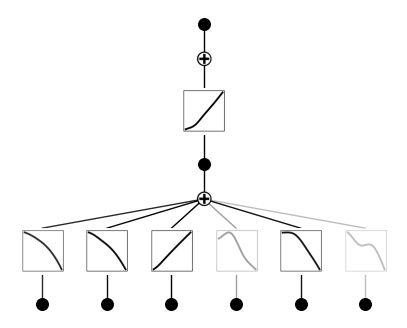

In [78]:
model(dataset['train_input'])
model.plot(beta=10)

In [79]:
# set the (1,0,0) activation to be gausssian
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

saving model version 0.1


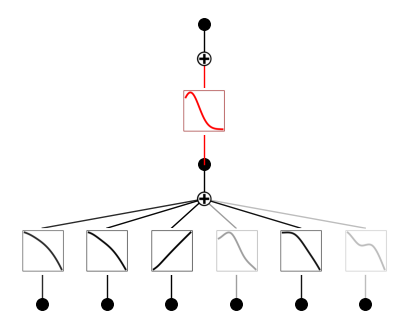

In [80]:
model(dataset['train_input'])
model.plot(beta=10)

In [81]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=10.0, lamb_coef=1.0)

| train_loss: 1.80e-01 | test_loss: 1.87e-01 | reg: 2.20e+01 | : 100%|█| 50/50 [00:05<00:00,  9.68it

saving model version 0.2


{'train_loss': [array(0.48942359),
  array(0.36751706),
  array(0.26731139),
  array(0.2677483),
  array(0.25231673),
  array(0.19931354),
  array(0.18901175),
  array(0.19198394),
  array(0.19730346),
  array(0.19622133),
  array(0.19314269),
  array(0.19060691),
  array(0.1894021),
  array(0.18926169),
  array(0.18806326),
  array(0.18933106),
  array(0.18859757),
  array(0.18470875),
  array(0.18419181),
  array(0.18185309),
  array(0.18013055),
  array(0.18054412),
  array(0.17991627),
  array(0.17959452),
  array(0.1792575),
  array(0.17972448),
  array(0.1796914),
  array(0.17996583),
  array(0.17980702),
  array(0.17991711),
  array(0.17983377),
  array(0.18019676),
  array(0.18023135),
  array(0.18017101),
  array(0.18011618),
  array(0.18014463),
  array(0.18012319),
  array(0.1800821),
  array(0.18006506),
  array(0.18004003),
  array(0.18001798),
  array(0.18000815),
  array(0.18000419),
  array(0.18000114),
  array(0.18000364),
  array(0.17999685),
  array(0.17999713),
  ar

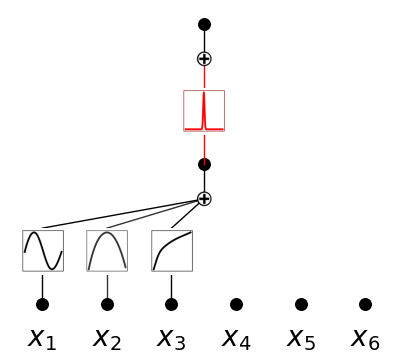

In [82]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

In [83]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
symbolic_functions_dict = model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9994234193034061, c=2
fixing (0,1,0) with x^2, r2=0.9977705946848335, c=2
fixing (0,2,0) with log, r2=0.9978698584631489, c=2
fixing (0,3,0) with x, r2=0.00424954079842419, c=1
fixing (0,4,0) with x, r2=4.922192533193343e-07, c=1
fixing (0,5,0) with x, r2=0.0017948677672512037, c=1
skipping (1,0,0) since already symbolic
saving model version 0.3


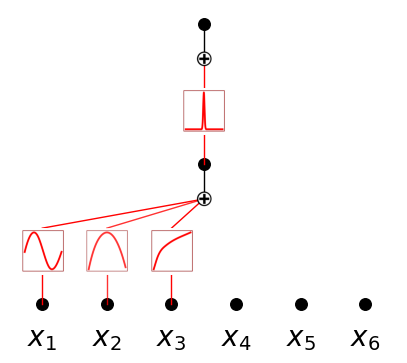

In [84]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)])

In [85]:
scores = model.edge_scores[0]

print(f"scores: {scores.squeeze(0).detach().cpu().tolist()}")

flat = scores.view(-1)
threshold = (flat.mean() + flat.std()) * 0.3

significant_indices = (flat > threshold).nonzero(as_tuple=True)[0]
formatted = [f'x{i.item() + 1}' for i in significant_indices]

print(f"significant features: {formatted}")


scores: [0.8995096040355054, 0.3687524268345571, 0.968244497637016, 2.5403684032126787e-06, 1.8071235275562596e-07, 1.1626316298503344e-06]
significant features: ['x1', 'x2', 'x3']


In [86]:
symbolic_functions_dict

{(0, 0, 0): ('sin', 0.9994234193034061),
 (0, 1, 0): ('x^2', 0.9977705946848335),
 (0, 2, 0): ('log', 0.9978698584631489),
 (0, 3, 0): ('x', 0.00424954079842419),
 (0, 4, 0): ('x', 4.922192533193343e-07),
 (0, 5, 0): ('x', 0.0017948677672512037),
 (1, 0, 0): ('already_symbolic', None)}